# **STORY MULTICLASS**

## **Preliminary steps**

In [1]:
### PACKAGES

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

In [2]:
### FUNCTIONS

from src.configs import constants, ml_config, names
from src.libs import preprocessing, evaluation, visualization
from src.embedding.tf_idf import TfIdfEmbedding
from src.embedding.punctuation import PunctuationEmbedding
from src.classifier.classifier import LightGBMClassifier, RFClassifier, NBClassifier

## **DATA**

In [3]:
### LOAD DATA

df_poetry_gpt = preprocessing.load_dataset(source="GPT", type="POETRY")
df_poetry_bard = preprocessing.load_dataset(source="BARD", type="POETRY")
df_poetry_human = preprocessing.load_dataset(source="Human", type="POETRY")

df_essay_gpt = preprocessing.load_dataset(source="GPT", type="ESSAY")
df_essay_bard = preprocessing.load_dataset(source="BARD", type="ESSAY")
df_essay_human = preprocessing.load_dataset(source="Human", type="ESSAY")

df_story_gpt = preprocessing.load_dataset(source="GPT", type="STORY")
df_story_bard = preprocessing.load_dataset(source="BARD", type="STORY")
df_story_human = preprocessing.load_dataset(source="Human", type="STORY")

Time taken to load dataset: 0.03226757049560547 seconds
Time taken to load dataset: 0.018144607543945312 seconds
Time taken to load dataset: 0.48070240020751953 seconds
Time taken to load dataset: 0.01767444610595703 seconds
Time taken to load dataset: 0.014076471328735352 seconds
Time taken to load dataset: 0.11050987243652344 seconds
Time taken to load dataset: 0.01871967315673828 seconds
Time taken to load dataset: 0.015906095504760742 seconds
Time taken to load dataset: 0.013532161712646484 seconds


In [4]:
### GET TRAIN SPLIT

df_train_poetry_gpt, df_test_poetry_gpt = preprocessing.train_valid_split(df_poetry_gpt)
df_train_poetry_bard, df_test_poetry_bard = preprocessing.train_valid_split(
    df_poetry_bard
)
df_train_poetry_human, df_test_poetry_human = preprocessing.train_valid_split(
    df_poetry_human
)

df_train_essay_gpt, df_test_essay_gpt = preprocessing.train_valid_split(df_essay_gpt)
df_train_essay_bard, df_test_essay_bard = preprocessing.train_valid_split(df_essay_bard)
df_train_essay_human, df_test_essay_human = preprocessing.train_valid_split(
    df_essay_human
)

df_train_story_gpt, df_test_story_gpt = preprocessing.train_valid_split(df_story_gpt)
df_train_story_bard, df_test_story_bard = preprocessing.train_valid_split(df_story_bard)
df_train_story_human, df_test_story_human = preprocessing.train_valid_split(
    df_story_human
)

In [5]:
### GET FULL DATASETS

df_train_story = preprocessing.get_story_dataset(
    df_train_story_gpt,
    df_train_story_bard,
    df_train_story_human,
    samples_per_source=min(
        len(df_train_story_gpt), len(df_train_story_bard), len(df_train_story_human)
    ),
)
df_test_story = preprocessing.get_story_dataset(
    df_test_story_gpt,
    df_test_story_bard,
    df_test_story_human,
    samples_per_source=None,
)

df_test_essay = preprocessing.get_essay_dataset(
    df_test_essay_gpt, df_test_essay_bard, df_test_essay_human, samples_per_source=None
)

df_test_poetry = preprocessing.get_poetry_dataset(
    df_test_poetry_gpt,
    df_test_poetry_bard,
    df_test_poetry_human,
    samples_per_source=None,
)

In [6]:
### SPLIT FEATURES AND LABELS

X_train_story, y_train_story = preprocessing.split_features_and_labels(df_train_story)
X_test_story, y_test_story = preprocessing.split_features_and_labels(df_test_story)
X_test_essay, y_test_essay = preprocessing.split_features_and_labels(df_test_essay)
X_test_poetry, y_test_poetry = preprocessing.split_features_and_labels(df_test_poetry)

## **CLASSIFICATION USING PUNCTUATION & RANDOM FOREST**

In [7]:
ID_EXPERIMENT = 211

In [8]:
### EMBEDDING

embedding_211 = PunctuationEmbedding(ID_EXPERIMENT)

X_train_story_211 = embedding_211.transform(X=X_train_story)
X_test_story_211 = embedding_211.transform(X=X_test_story)
X_test_essay_211 = embedding_211.transform(X=X_test_essay)
X_test_poetry_211 = embedding_211.transform(X=X_test_poetry)

In [9]:
### CLASSIFIER

classifier_211 = LightGBMClassifier(ID_EXPERIMENT)

classifier_211.train(X_train=X_train_story_211, y_train=y_train_story)

metrics_story_211 = classifier_211.evaluate(X_test_story_211, y_test_story)
metrics_essay_211 = classifier_211.evaluate(X_test_essay_211, y_test_essay)
metrics_poetry_211 = classifier_211.evaluate(X_test_poetry_211, y_test_poetry)

print(f"Metrics on story: {metrics_story_211}")
print(f"Metrics on essay: {metrics_essay_211}")
print(f"Metrics on poetry: {metrics_poetry_211}")

Metrics on story: {'accuracy': 0.7818181818181819, 'precision': 0.7111111111111111, 'recall': 0.7111111111111111, 'f1': 0.7111111111111111}
Metrics on essay: {'accuracy': 0.4280442804428044, 'precision': 0.3356676003734827, 'recall': 0.3817813765182186, 'f1': 0.24581884417949992}
Metrics on poetry: {'accuracy': 0.6676136363636364, 'precision': 0.34173619322909826, 'recall': 0.45090469279148526, 'f1': 0.29316342093653497}


In [10]:
### INTERPRETABILITY - FEATURE IMPORTANCE

dim_names_211 = embedding_211.map_dimensions_to_names()
feature_importances_211 = classifier_211.get_feature_importance()
most_important_features_211 = np.argsort(feature_importances_211)[-10:][::-1]
for i in most_important_features_211:
    print(f"{dim_names_211[i]}: {feature_importances_211[i]}")

ratio_words_per_sentence: 1233
ratio_punctuations: 999
ratio_odd_characters: 801


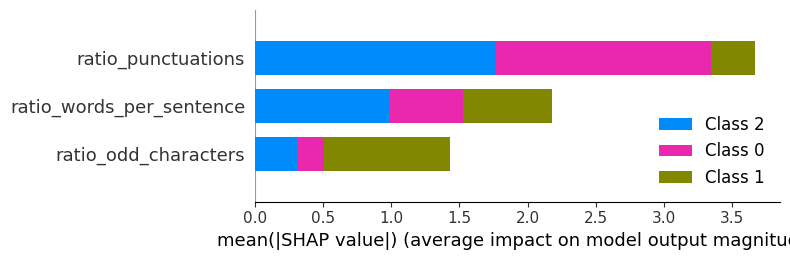

In [11]:
### INTERPRETABILITY - SHAP VALUES

explainer_211 = shap.Explainer(classifier_211.classifier)

if hasattr(X_test_story_211, "toarray"):
    X_test_story_211 = X_test_story_211.toarray()

# Calculate SHAP values
shap_values_211 = explainer_211(X_test_story_211)

# Visualize the SHAP values
shap.summary_plot(shap_values_211, X_test_story_211, feature_names=dim_names_211)

## **CLASSIFICATION USING TF-IDF & LGBM**

In [12]:
ID_EXPERIMENT = 111

In [13]:
### EMBEDDING

embedding_111 = TfIdfEmbedding(ID_EXPERIMENT)

embedding_111.fit(X=X_train_story)

X_train_story_111 = embedding_111.transform(X=X_train_story)
X_test_story_111 = embedding_111.transform(X=X_test_story)
X_test_essay_111 = embedding_111.transform(X=X_test_essay)
X_test_poetry_111 = embedding_111.transform(X=X_test_poetry)

In [14]:
### CLASSIFIER

classifier_111 = LightGBMClassifier(ID_EXPERIMENT)

classifier_111.train(X_train=X_train_story_111, y_train=y_train_story)

metrics_story_111 = classifier_111.evaluate(X_test_story_111, y_test_story)
metrics_essay_111 = classifier_111.evaluate(X_test_essay_111, y_test_essay)
metrics_poetry_111 = classifier_111.evaluate(X_test_poetry_111, y_test_poetry)

print(f"Metrics on story: {metrics_story_111}")
print(f"Metrics on essay: {metrics_essay_111}")
print(f"Metrics on poetry: {metrics_poetry_111}")

Metrics on story: {'accuracy': 0.8545454545454545, 'precision': 0.7809139784946236, 'recall': 0.7666666666666666, 'f1': 0.7711185537732339}
Metrics on essay: {'accuracy': 0.7822878228782287, 'precision': 0.3336842105263158, 'recall': 0.3167341430499325, 'f1': 0.3243664717348928}
Metrics on poetry: {'accuracy': 0.7798295454545454, 'precision': 0.3353229656642531, 'recall': 0.35724238026124816, 'f1': 0.3076971598315102}


In [15]:
### INTERPRETABILITY - FEATURE IMPORTANCE

dim_names_111 = embedding_111.map_dimensions_to_names()
feature_importances_111 = classifier_111.get_feature_importance()
most_important_features_111 = np.argsort(feature_importances_111)[-10:][::-1]
for i in most_important_features_111:
    print(f"{dim_names_111[i]}: {feature_importances_111[i]}")

world: 236
day: 143
use: 124
like: 111
couldn: 88
just: 83
place: 79
heart: 76
don: 74
story: 73


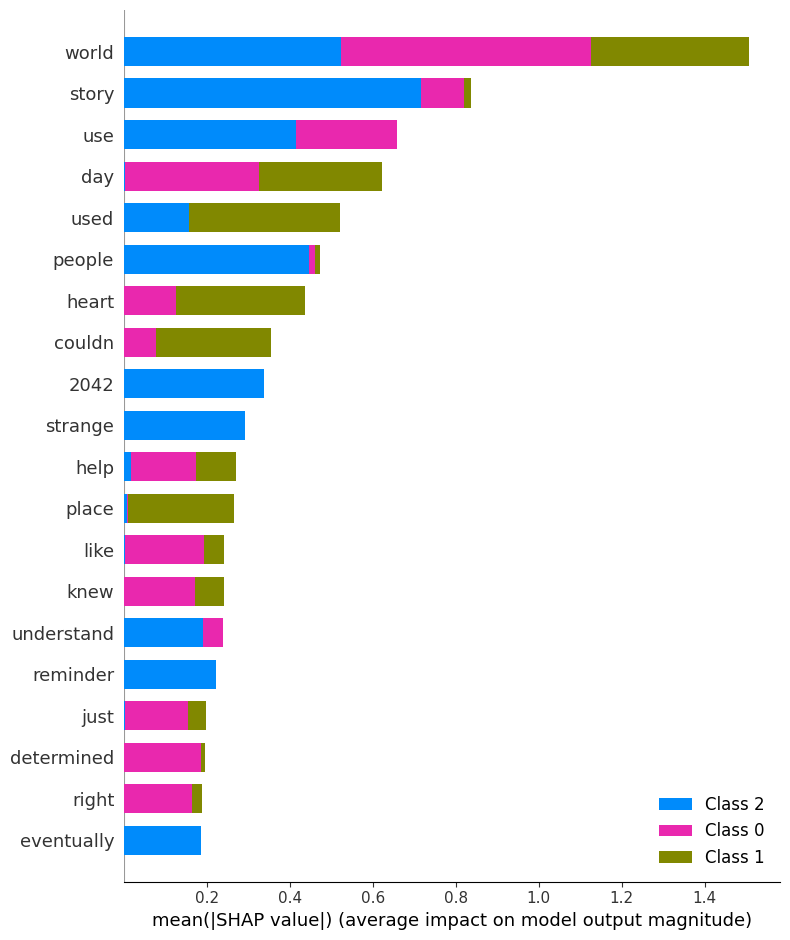

In [16]:
### INTERPRETABILITY - SHAP VALUES

explainer_111 = shap.Explainer(classifier_111.classifier)

if hasattr(X_test_story_111, "toarray"):
    X_test_story_111 = X_test_story_111.toarray()

# Calculate SHAP values
shap_values_111 = explainer_111(X_test_story_111)


# Visualize the SHAP values
shap.summary_plot(shap_values_111, X_test_story_111, feature_names=dim_names_111)

## **CLASSIFICATION USING TF-IDF & RANDOM FOREST**

In [17]:
ID_EXPERIMENT = 121

In [18]:
### EMBEDDING

embedding_121 = TfIdfEmbedding(ID_EXPERIMENT)

embedding_121.fit(X=X_train_story)

X_train_story_121 = embedding_121.transform(X=X_train_story)
X_test_story_121 = embedding_121.transform(X=X_test_story)
X_test_essay_121 = embedding_121.transform(X=X_test_essay)
X_test_poetry_121 = embedding_121.transform(X=X_test_poetry)

In [19]:
### CLASSIFIER

classifier_121 = RFClassifier(ID_EXPERIMENT)

classifier_121.train(X_train=X_train_story_121, y_train=y_train_story)

metrics_story_121 = classifier_121.evaluate(X_test_story_121, y_test_story)
metrics_essay_121 = classifier_121.evaluate(X_test_essay_121, y_test_essay)
metrics_poetry_121 = classifier_121.evaluate(X_test_poetry_121, y_test_poetry)

print(f"Metrics on story: {metrics_story_121}")
print(f"Metrics on essay: {metrics_essay_121}")
print(f"Metrics on poetry: {metrics_poetry_121}")

Metrics on story: {'accuracy': 0.9090909090909091, 'precision': 0.8783068783068783, 'recall': 0.8444444444444444, 'f1': 0.8514557338086751}
Metrics on essay: {'accuracy': 0.8819188191881919, 'precision': 0.3052362707535121, 'recall': 0.3225371120107962, 'f1': 0.3136482939632546}
Metrics on poetry: {'accuracy': 0.9453125, 'precision': 0.33370685791125054, 'recall': 0.33505563618771167, 'f1': 0.33346374543557644}


## **CLASSIFICATION USING TF-IDF & NAIVE BAYES**

In [20]:
ID_EXPERIMENT = 131

In [21]:
### EMBEDDING

embedding_131 = TfIdfEmbedding(ID_EXPERIMENT)

embedding_131.fit(X=X_train_story)

X_train_story_131 = embedding_131.transform(X=X_train_story)
X_test_story_131 = embedding_131.transform(X=X_test_story)
X_test_essay_131 = embedding_131.transform(X=X_test_essay)
X_test_poetry_131 = embedding_131.transform(X=X_test_poetry)

In [22]:
### CLASSIFIER

classifier_131 = NBClassifier(ID_EXPERIMENT)

classifier_131.train(X_train=X_train_story_131, y_train=y_train_story)

metrics_story_131 = classifier_131.evaluate(X_test_story_131, y_test_story)
metrics_essay_131 = classifier_131.evaluate(X_test_essay_131, y_test_essay)
metrics_poetry_131 = classifier_131.evaluate(X_test_poetry_131, y_test_poetry)

print(f"Metrics on story: {metrics_story_131}")
print(f"Metrics on essay: {metrics_essay_131}")
print(f"Metrics on poetry: {metrics_poetry_131}")

Metrics on story: {'accuracy': 0.8181818181818182, 'precision': 0.8692185007974483, 'recall': 0.7333333333333334, 'f1': 0.7748868778280542}
Metrics on essay: {'accuracy': 0.8081180811808119, 'precision': 0.35802469135802467, 'recall': 0.6234817813765182, 'f1': 0.3562223217395631}
Metrics on poetry: {'accuracy': 0.27201704545454547, 'precision': 0.3349641226353555, 'recall': 0.424770198355104, 'f1': 0.14675367211337917}
